## Proyect|eSTI

In [41]:
import pandas as pd
import numpy as np

In [42]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import multipletests

import pandas as pd
import numpy as np
import statsmodels.api as sm

from statsmodels.stats.multitest import multipletests



In [43]:
## loading the data
df = pd.read_csv('processed_esti.csv')
df

,y,w,gender_female,gender_male,gender_transgender,ethnicgrp_asian,ethnicgrp_black,ethnicgrp_mixed_multiple,ethnicgrp_other,ethnicgrp_white,partners1,postlaunch,msm,age,imd_decile
0,1,1,0,1,0,0,0,1,0,0,0,1,0,27,5
1,0,0,0,1,0,0,0,0,0,1,0,0,0,19,6
2,0,1,0,1,0,0,1,0,0,0,0,1,0,26,4
3,0,0,1,0,0,0,0,0,0,1,1,0,0,20,2
4,1,1,1,0,0,1,0,0,0,0,0,1,0,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,0,0,0,1,0,0,0,0,0,1,0,0,0,24,8
1735,1,1,1,0,0,0,1,0,0,0,1,1,0,29,1
1736,1,1,1,0,0,0,0,0,0,1,0,1,0,27,4
1737,0,1,1,0,0,0,0,0,0,1,1,1,0,25,4


In [44]:
import econml
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from sklearn.linear_model import MultiTaskLassoCV
# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.grf import RegressionForest
%matplotlib inline
import patsy
import seaborn as sns

In [45]:
# Preparing data to fit a causal forest

fmla = '0+gender_female+gender_male+gender_transgender+ethnicgrp_asian+ethnicgrp_black+ethnicgrp_mixed_multiple+ethnicgrp_other+ethnicgrp_white+partners1+postlaunch+msm+age+imd_decile'
desc = patsy.ModelDesc.from_formula(fmla)
desc.describe()
matrix = patsy.dmatrix(fmla, df, return_type = "dataframe")

T = df.loc[ : ,"w"]
Y = df.loc[ : ,"y"]
X = matrix
W = None

# Estimate a causal forest.
est2 = CausalForestDML(model_t=RegressionForest(),
                       model_y=RegressionForest(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)

est2.tune(Y, T, X=X, W=W)
est2.fit(Y, T, X=X, W=W)

In [46]:
# Get residuals  and propensity
residuals = est2.fit(Y, T, X=X, W=W, cache_values=True).residuals_
T_res = residuals[1]
e_hat = T - T_res

# T = beta_hat*X + e , beta_hat*X = T_hat = T-e

In [47]:
Prop = pd.DataFrame({"p_score":e_hat, "Treatment":T})

<Axes: xlabel='p_score', ylabel='Count'>

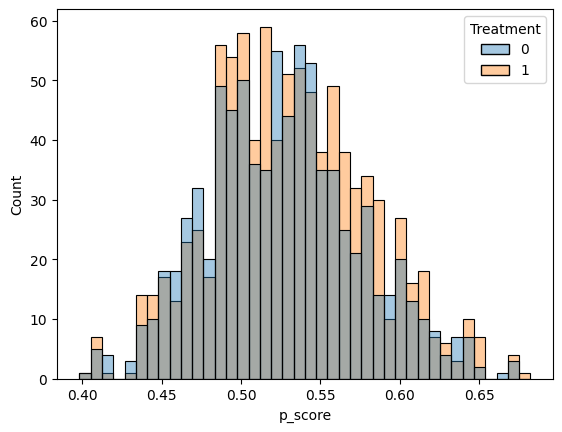

In [48]:
#Propensity score

sns.histplot(data=Prop, x="p_score", hue="Treatment", bins=40, alpha = 0.4)

In [49]:
tau_hat = est2.effect(X=X) # tau(X) estimates

In [50]:
tau_hat

array([0.24181639, 0.18535884, 0.26840456, ..., 0.33914207, 0.33173903,
       0.33457322])

Text(0.5, 1.0, 'CATE estimates')

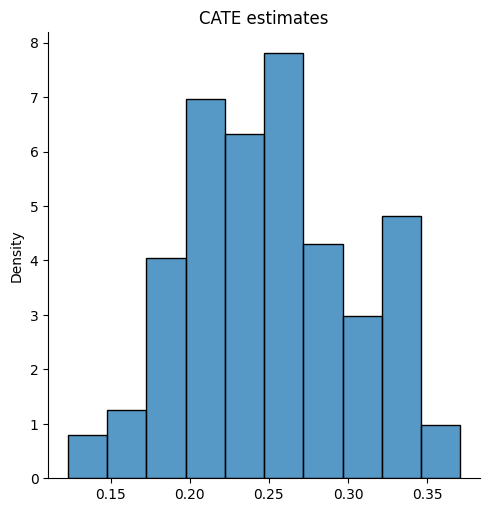

In [51]:
# Do not use this for assessing heterogeneity. See text above.
sns.displot( tau_hat, stat="density", bins = 10)
plt.title("CATE estimates")

In [52]:
est2.feature_importances()

array([0.03564248, 0.13795092, 0.        , 0.01649403, 0.0061992 ,
       0.02700427, 0.        , 0.05619125, 0.0289925 , 0.25403209,
       0.03981383, 0.28393271, 0.1137467 ])

In [53]:
importance = pd.DataFrame({"covariaties" : list(X.columns), "values" : est2.feature_importances()})

In [54]:
importance.sort_values('values', ascending = False)

,covariaties,values
11,age,0.283933
9,postlaunch,0.254032
1,gender_male,0.137951
12,imd_decile,0.113747
7,ethnicgrp_white,0.056191
10,msm,0.039814
0,gender_female,0.035642
8,partners1,0.028993
5,ethnicgrp_mixed_multiple,0.027004
3,ethnicgrp_asian,0.016494


In [55]:
from econml.dml import CausalForestDML
np.random.seed(0)
tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=3)
X='gender_female+gender_male+gender_transgender+ethnicgrp_asian+ethnicgrp_black+ethnicgrp_mixed_multiple+ethnicgrp_other+ethnicgrp_white+partners1+postlaunch+msm+age+imd_decile'.split('+')
tree_model = tree_model.fit(Y=df['y'], X=df[X], T=df['w'])
print(tree_model)

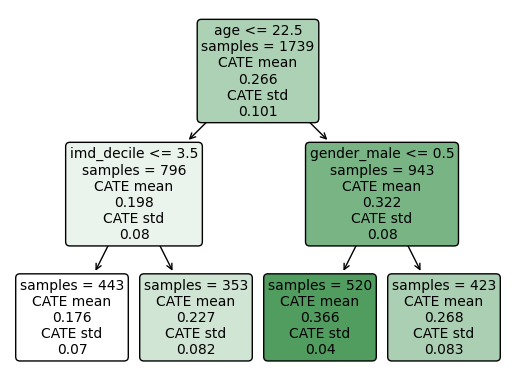

In [56]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, df[X])
intrp.plot(feature_names=X, fontsize=10)